In [15]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

In [16]:
# Load dataset
df = pd.read_csv("/content/IMDB Dataset.csv")

# Convert sentiment labels to binary
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})

# Split into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["review"], df["label"], test_size=0.2, random_state=42
)

In [17]:
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

In [18]:
# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
model = AutoModelForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base")

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Define tokenization function
def tokenizer_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

# Apply tokenization
tokenized_train_dataset = train_dataset.map(tokenizer_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenizer_function, batched=True)

# Rename 'label' → 'labels', remove 'text', and set torch format
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels").remove_columns(["text"])
tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels").remove_columns(["text"])

# Set format for PyTorch (include all necessary columns)
tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [20]:
# Training
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir='./logs',
    logging_steps=10,
)

In [21]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
)

In [38]:
# Prepare batches
batch_size = 32
pred_labels = []

for i in tqdm(range(0, len(test_texts), batch_size)):
    batch_texts = test_texts[i:i+batch_size].tolist()
    batch_texts = [text[:512] for text in batch_texts]

    results = classifier(batch_texts)

    batch_preds = [1 if res["label"] == "POSITIVE" else 0 for res in results]
    pred_labels.extend(batch_preds)

100%|██████████| 313/313 [01:24<00:00,  3.72it/s]


In [33]:
# Accuracy
acc = accuracy_score(test_labels[:len(pred_labels)], pred_labels)
print(f"Accuracy on full IMDb test set: {acc * 100:.2f}%")

Accuracy on full IMDb test set: 82.47%


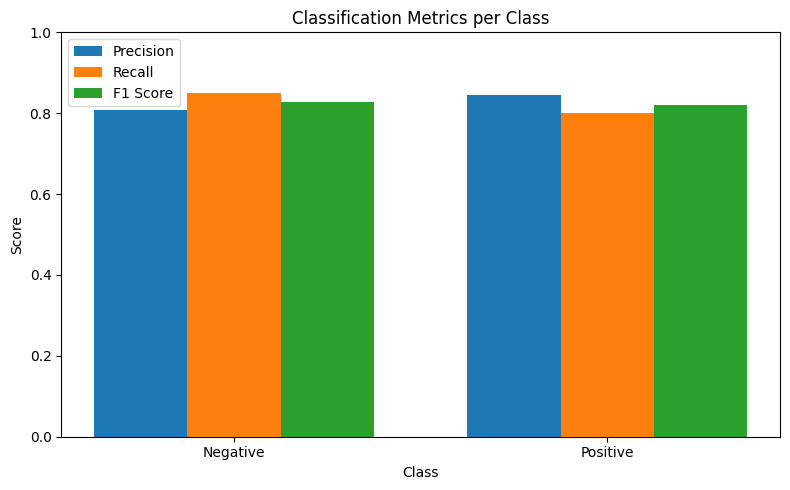

In [35]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Generate classification report
report_dict = classification_report(test_labels[:len(pred_labels)], pred_labels, target_names=["Negative", "Positive"], output_dict=True)

# Extract class-wise metrics
labels = ["Negative", "Positive"]
precision = [report_dict[label]["precision"] for label in labels]
recall = [report_dict[label]["recall"] for label in labels]
f1 = [report_dict[label]["f1-score"] for label in labels]

# Bar plot
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Classification Metrics per Class")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

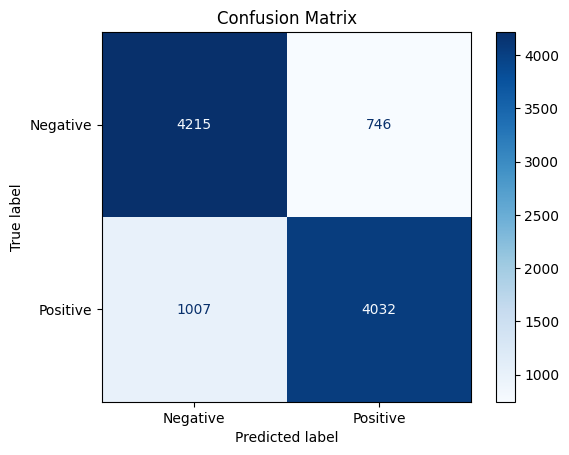

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(test_labels[:len(pred_labels)], pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()